In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras import models, Model
import qkeras
from qkeras import *

# two new layers
# 1) a input_reduce layer that cut off pixels at n_max_pixels with a feature threshold, output reduced map and a mask (1 for active, 0 for nonactive) (no threshold for this for hidden layers the output from previous layer can be standardized etc)
# 2) a mask_remove layer that remove nonactive pixels according to the mask from input_reduce, to be used after a normal qconv2d layer
# so sparse cnn: input -> input_reduce -> qconv2d -> mask_remove -> qactivation -> qpooling -> input_reduce (to generate updated mask) -> qconv2d -> mask_remove -> qactivation -> flatten -> ...

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

n_val = 10000
X_val = X_train[:n_val]
y_val = y_train[:n_val]
X_train = X_train[n_val:]
y_train = y_train[n_val:]

X_train = np.reshape(X_train, (-1,28,28,1)) / 255.
X_val = np.reshape(X_val, (-1,28,28,1)) / 255.
X_test = np.reshape(X_test, (-1,28,28,1)) / 255.

y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

print("X_train.shape: " + str(X_train.shape))
print("y_train.shape: " + str(y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("y_val.shape: " + str(y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("y_test.shape: " + str(y_test.shape))

X_train.shape: (50000, 28, 28, 1)
y_train.shape: (50000, 10)
X_val.shape: (10000, 28, 28, 1)
y_val.shape: (10000, 10)
X_test.shape: (10000, 28, 28, 1)
y_test.shape: (10000, 10)


In [3]:
def pool_and_pad_and_threshold(img, pool_size, pool_type, target_size=None, threshold=0):
    x = tf.convert_to_tensor(img, dtype=tf.float32)
    #x = tf.where(x<threshold, tf.zeros_like(x), x)

    k_h = k_w = pool_size

    if pool_type == 'max':
        pooled = tf.nn.max_pool2d(x, ksize=[1, k_h, k_w, 1], strides=[1, k_h, k_w, 1], padding='VALID')
    elif pool_type in ('avg'):
        pooled = tf.nn.avg_pool2d(x, ksize=[1, k_h, k_w, 1], strides=[1, k_h, k_w, 1], padding='VALID')

    old_h = tf.shape(x)[1]
    old_w = tf.shape(x)[2]
    new_h  = tf.shape(pooled)[1]
    new_w  = tf.shape(pooled)[2]

    if target_size is None:
        target_h, target_w = old_h, old_w
    else:
        target_h, target_w = target_size

    pad_y = target_h - new_h
    pad_x = target_w - new_w
    pad_top = pad_y // 2
    pad_bottom = pad_y - pad_top
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left

    padded = tf.pad(
        pooled,
        [[0, 0], # batch
         [pad_top, pad_bottom], # h
         [pad_left, pad_right], # w
         [0, 0]], # c
        mode='CONSTANT',
        constant_values=0
    )

    max_per_img = tf.reduce_max(padded, axis=[1,2,3], keepdims=True)
    padded = tf.math.divide_no_nan(padded, max_per_img)
    padded = tf.where(padded<threshold, tf.zeros_like(padded), padded)

    return padded.numpy()

def plot_sparse(x_original, x_modified, n_example):
    img1 = x_original[n_example+1011]
    img2 = x_modified[n_example+1011]

    print('no. of active pixels (original): ' + str(np.count_nonzero(img1)) + ' / ' + str(img1.size) + ' = ' + str(np.count_nonzero(img1)/img1.size))
    print('no. of active pixels (modified): ' + str(np.count_nonzero(img2)) + ' / ' + str(img2.size) + ' = ' + str(np.count_nonzero(img2)/img2.size))

    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    plt.show()

no. of active pixels (original): 151 / 784 = 0.19260204081632654
no. of active pixels (modified): 16 / 1600 = 0.01


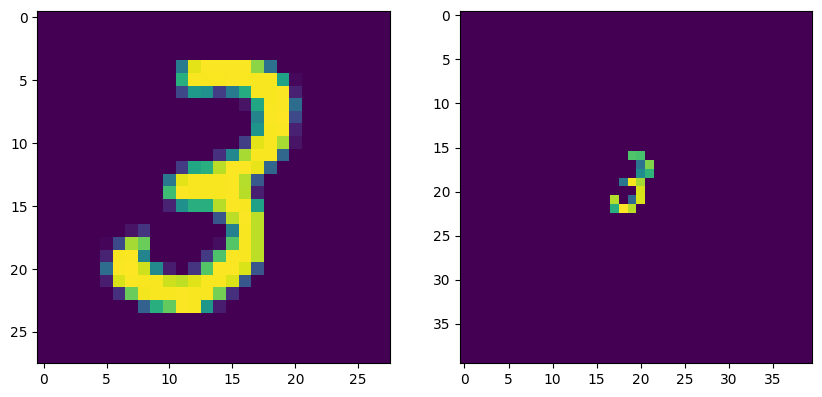

no. of active pixels (original): 129 / 784 = 0.16454081632653061
no. of active pixels (modified): 14 / 1600 = 0.00875


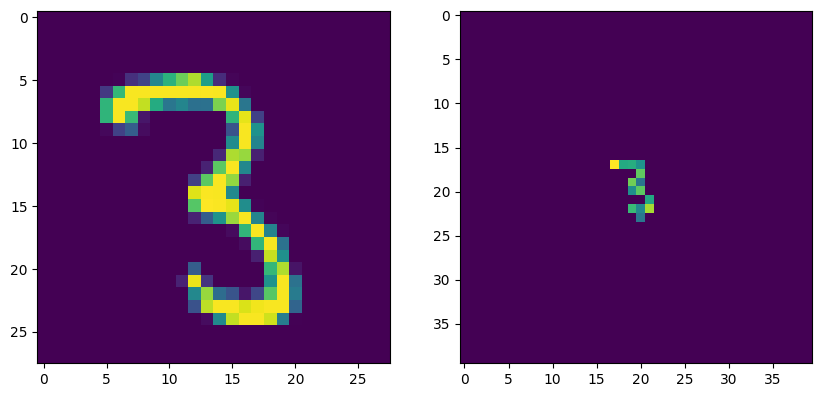

no. of active pixels (original): 197 / 784 = 0.2512755102040816
no. of active pixels (modified): 19 / 1600 = 0.011875


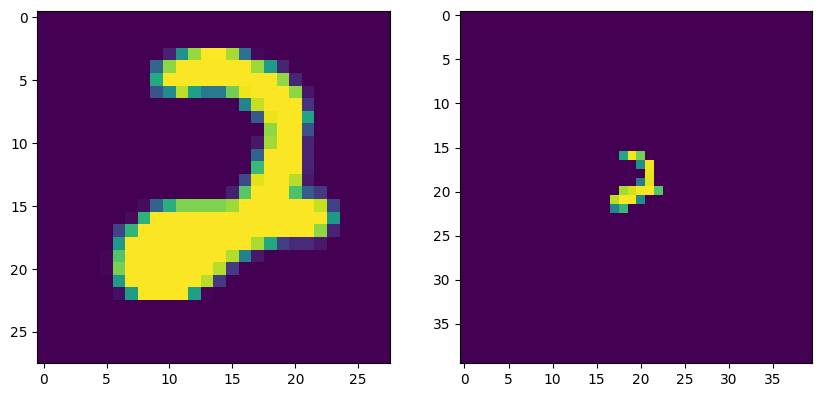

no. of active pixels (original): 177 / 784 = 0.22576530612244897
no. of active pixels (modified): 21 / 1600 = 0.013125


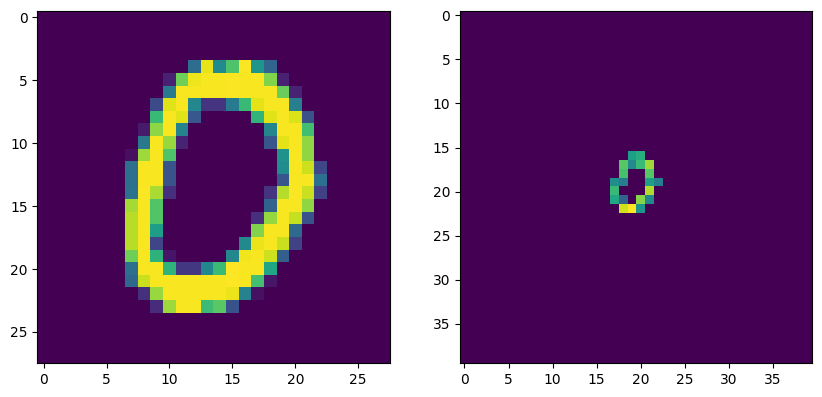

no. of active pixels (original): 162 / 784 = 0.2066326530612245
no. of active pixels (modified): 19 / 1600 = 0.011875


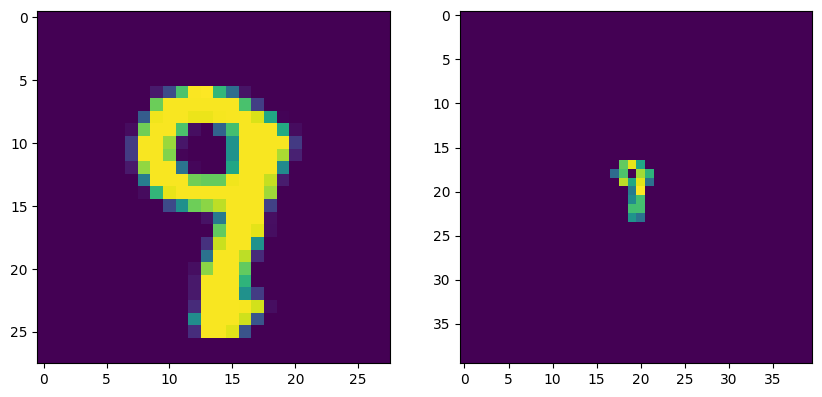

In [4]:
x_train = pool_and_pad_and_threshold(X_train, pool_size=3, pool_type='avg', target_size=(40,40), threshold=0.3)
x_val = pool_and_pad_and_threshold(X_val, pool_size=3, pool_type='avg', target_size=(40,40), threshold=0.3)
x_test = pool_and_pad_and_threshold(X_test, pool_size=3, pool_type='avg', target_size=(40,40), threshold=0.3)

for i in range(5):
    plot_sparse(X_train, x_train, i)

In [5]:
class InputReduce(tf.keras.layers.Layer):
    def __init__(self, n_max_pixels, threshold, **kwargs):
        super(InputReduce, self).__init__(**kwargs)
        self.n_max_pixels = n_max_pixels
        self.threshold = threshold

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        h = tf.shape(inputs)[1]
        w = tf.shape(inputs)[2]

        if self.threshold is not None:
            active_flag = tf.cast(inputs[..., 0] > self.threshold, tf.int32)
        else:
            active_flag = tf.cast(inputs[..., 0] != 0, tf.int32)
        active_flag_flat = tf.reshape(active_flag, [batch_size, h * w])
        active_count = tf.cumsum(active_flag_flat, axis=1)

        keep_mask_flat = tf.cast(tf.logical_and(active_flag_flat == 1, active_count <= self.n_max_pixels), inputs.dtype)
        keep_mask = tf.reshape(keep_mask_flat, [batch_size, h, w, 1])

        inputs_reduced = inputs * keep_mask
        return inputs_reduced, keep_mask

    def get_config(self):
        config = super(InputReduce, self).get_config()
        config.update({
            "n_max_pixels": self.n_max_pixels,
            "threshold": self.threshold
        })
        return config
    

class RemoveDilatedPixels(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RemoveDilatedPixels, self).__init__(**kwargs)

    def call(self, inputs):
        x, mask = inputs
        mask = tf.cast(mask, x.dtype)
        removed = x * mask
        return removed

    def get_config(self):
        config = super(RemoveDilatedPixels, self).get_config()
        return config

In [ ]:
for i, img in enumerate(x_train[:2]):
    print(f"Example {i}:")
    img2d = img[..., 0]
    for row in img2d:
        row_str = " ".join(
            "_____" if val == 0 
            else f"{val:.3f}"
            for val in row
        )
        print(row_str)
    print()

In [ ]:
xx, mask = InputReduce(n_max_pixels=10, threshold=0.3)(x_train[:2])
xxx = RemoveDilatedPixels()((xx, mask))
print(xx.shape, xxx.shape)

In [ ]:
for i, img in enumerate(xxx[:2]):
    print(f"Example {i}:")
    img2d = img[..., 0]
    for row in img2d:
        row_str = " ".join(
            "_____" if val == 0
            else f"{val:.3f}"
            for val in row
        )
        print(row_str)
    print()

In [ ]:
quantizer = quantized_bits(6, 0, alpha=1)
quantized_relu = 'quantized_relu(6, 0)'

x_in = keras.Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name='x_in')
x, mask = InputReduce(n_max_pixels=20, threshold=0.1, name='reduce1')(x_in)

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv1',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = RemoveDilatedPixels(name='remove1')((x, mask))
x = QActivation(quantized_relu, name='relu1')(x)

x = AveragePooling2D(2, name='pool1')(x)
x, mask = InputReduce(n_max_pixels=20, threshold=None, name='reduce2')(x) ########

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv2',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = RemoveDilatedPixels(name='remove2')((x, mask))
x = QActivation(quantized_relu, name='relu2')(x)

x = AveragePooling2D(2, name='pool2')(x)
x, mask = InputReduce(n_max_pixels=20, threshold=None, name='reduce3')(x)

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv3',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = RemoveDilatedPixels(name='remove3')((x, mask))
x = QActivation(quantized_relu, name='relu3')(x)

x = Flatten(name='flatten')(x)

x = QDense(32, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense1')(x)
x = QActivation(quantized_relu, name='relu4')(x)

x = QDense(10, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense2')(x)
x = Activation('softmax', name='softmax')(x)

cnn_sparse = keras.Model(x_in, x, name='cnn_sparse')

cnn_sparse.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_sparse.summary()

Model: "test_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_in (InputLayer)           [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 reduce1 (InputReduce)       ((None, 40, 40, 1),          0         ['x_in[0][0]']                
                              (None, 40, 40, 1))                                                  
                                                                                                  
 conv1 (QConv2D)             (None, 40, 40, 3)            30        ['reduce1[0][0]']             
                                                                                                  
 remove1 (RemoveDilatedPixe  (None, 40, 40, 3)            0         ['conv1[0][0]',      

In [36]:
quantizer = quantized_bits(6, 0, alpha=1)
quantized_relu = 'quantized_relu(6, 0)'

x_in = keras.Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name='x_in')

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv1',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x_in)
x = QActivation(quantized_relu, name='relu1')(x)

x = AveragePooling2D(2, name='pool1')(x)

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv2',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = QActivation(quantized_relu, name='relu2')(x)

x = AveragePooling2D(2, name='pool2')(x)

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv3',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = QActivation(quantized_relu, name='relu3')(x)

x = Flatten(name='flatten')(x)

x = QDense(32, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense1')(x)
x = QActivation(quantized_relu, name='relu4')(x)

x = QDense(10, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense2')(x)
x = Activation('softmax', name='softmax')(x)

cnn_full = keras.Model(x_in, x, name='cnn_full')

cnn_full.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_full.summary()

Model: "cnn_full"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_in (InputLayer)           [(None, 40, 40, 1)]       0         
                                                                 
 conv1 (QConv2D)             (None, 40, 40, 3)         30        
                                                                 
 relu1 (QActivation)         (None, 40, 40, 3)         0         
                                                                 
 pool1 (AveragePooling2D)    (None, 20, 20, 3)         0         
                                                                 
 conv2 (QConv2D)             (None, 20, 20, 3)         84        
                                                                 
 relu2 (QActivation)         (None, 20, 20, 3)         0         
                                                                 
 pool2 (AveragePooling2D)    (None, 10, 10, 3)         0  

Epoch 1/30
391/391 [==============================] - 5s 12ms/step - loss: 1.9747 - accuracy: 0.2984 - val_loss: 1.5991 - val_accuracy: 0.4489
Epoch 2/30
391/391 [==============================] - 4s 11ms/step - loss: 1.4163 - accuracy: 0.5217 - val_loss: 1.2756 - val_accuracy: 0.5705
Epoch 3/30
391/391 [==============================] - 4s 11ms/step - loss: 1.2061 - accuracy: 0.5920 - val_loss: 1.1404 - val_accuracy: 0.6111
Epoch 4/30
391/391 [==============================] - 5s 12ms/step - loss: 1.0779 - accuracy: 0.6377 - val_loss: 1.0242 - val_accuracy: 0.6526
Epoch 5/30
391/391 [==============================] - 5s 12ms/step - loss: 0.9812 - accuracy: 0.6737 - val_loss: 0.9405 - val_accuracy: 0.6897
Epoch 6/30
391/391 [==============================] - 4s 11ms/step - loss: 0.9020 - accuracy: 0.7063 - val_loss: 0.8640 - val_accuracy: 0.7269
Epoch 7/30
391/391 [==============================] - 5s 12ms/step - loss: 0.8395 - accuracy: 0.7321 - val_loss: 0.8086 - val_accuracy: 0.7442

Text(0, 0.5, 'Loss')

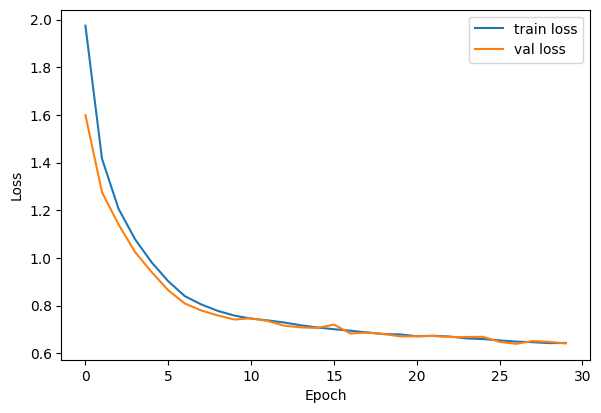

In [ ]:
history = cnn_sparse.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

Epoch 1/30
391/391 [==============================] - 4s 9ms/step - loss: 1.6229 - accuracy: 0.4824 - val_loss: 1.0460 - val_accuracy: 0.6797
Epoch 2/30
391/391 [==============================] - 4s 10ms/step - loss: 0.8653 - accuracy: 0.7306 - val_loss: 0.7241 - val_accuracy: 0.7771
Epoch 3/30
391/391 [==============================] - 4s 10ms/step - loss: 0.6700 - accuracy: 0.7895 - val_loss: 0.5986 - val_accuracy: 0.8128
Epoch 4/30
391/391 [==============================] - 4s 10ms/step - loss: 0.5732 - accuracy: 0.8203 - val_loss: 0.5199 - val_accuracy: 0.8366
Epoch 5/30
391/391 [==============================] - 4s 10ms/step - loss: 0.5108 - accuracy: 0.8409 - val_loss: 0.4806 - val_accuracy: 0.8536
Epoch 6/30
391/391 [==============================] - 4s 10ms/step - loss: 0.4569 - accuracy: 0.8574 - val_loss: 0.4328 - val_accuracy: 0.8681
Epoch 7/30
391/391 [==============================] - 4s 9ms/step - loss: 0.4236 - accuracy: 0.8694 - val_loss: 0.4046 - val_accuracy: 0.8748
E

Text(0, 0.5, 'Loss')

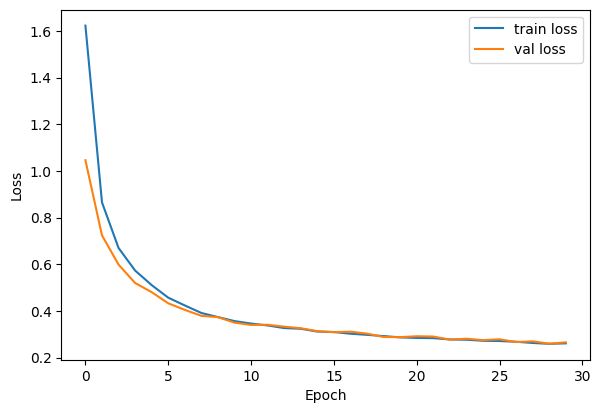

In [37]:
history = cnn_full.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [38]:
y_pred_sparse = cnn_sparse.predict(x_test)
y_pred_full = cnn_full.predict(x_test)
print("accuracy (sparse cnn) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse, axis=1))))
print("accuracy (full cnn) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_full, axis=1))))

313/313 [==============================] - 1s 2ms/step
accuracy (sparse cnn) = 0.792
accuracy (full cnn) = 0.9187


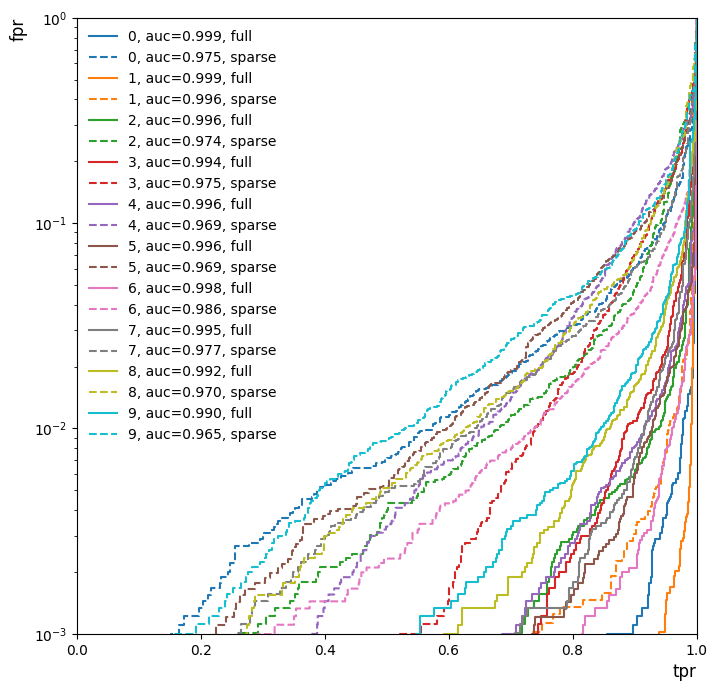

In [45]:
def plot_roc(y_test, y_pred_sparse, y_pred_full, labels):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for x, label in enumerate(labels):
        color = colors[x % len(colors)]
        fpr_full, tpr_full, _ = roc_curve(y_test[:, x], y_pred_full[:, x])
        plt.plot(tpr_full, fpr_full, label='{0}, auc={1:.3f}, full'.format(label, auc(fpr_full, tpr_full)), linestyle='-', lw=1.5, color=color)
        fpr_sparse, tpr_sparse, _ = roc_curve(y_test[:, x], y_pred_sparse[:, x])
        plt.plot(tpr_sparse, fpr_sparse, label='{0}, auc={1:.3f}, sparse'.format(label, auc(fpr_sparse, tpr_sparse)), linestyle='--', lw=1.5, color=color)
    plt.semilogy()
    plt.xlabel("tpr", size=12, loc='right')
    plt.ylabel("fpr", size=12, loc='top')
    plt.xlim(0, 1)
    plt.ylim(0.001, 1)
    plt.legend(loc='best', framealpha=0., prop={'size': 10})

plt.figure(figsize=(8, 8))
plot_roc(y_test, y_pred_sparse, y_pred_full, ['0','1','2','3','4','5','6','7','8','9'])

1/1 [==============================] - 0s 149ms/step


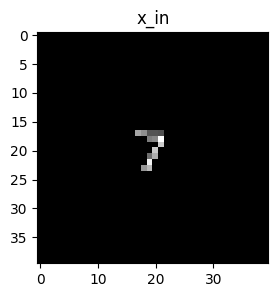

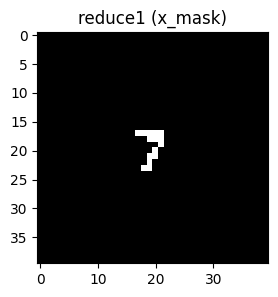

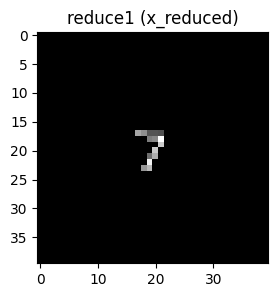

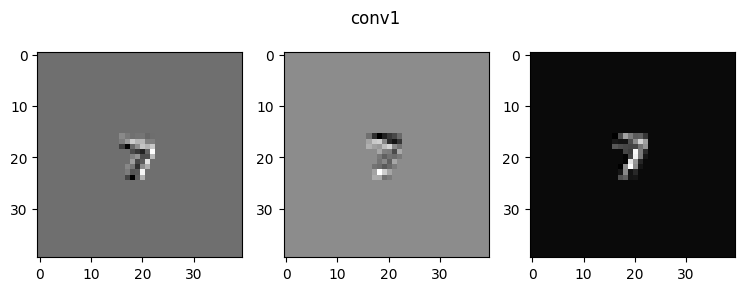

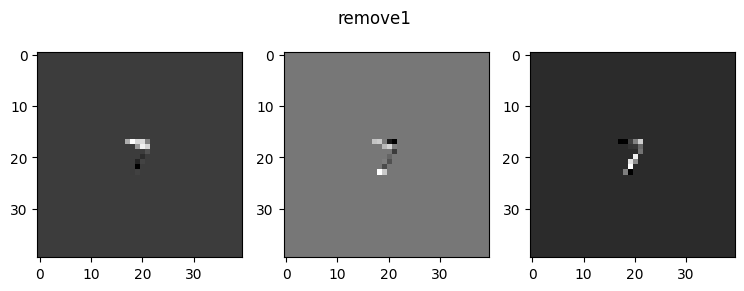

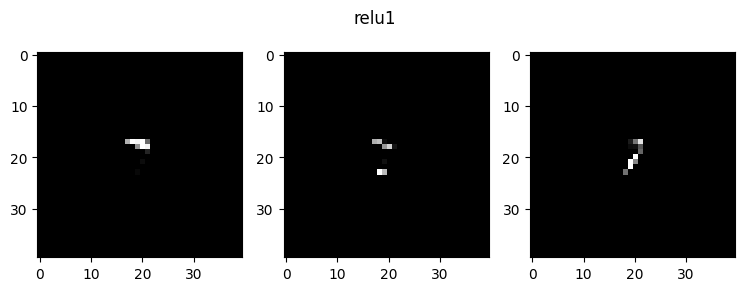

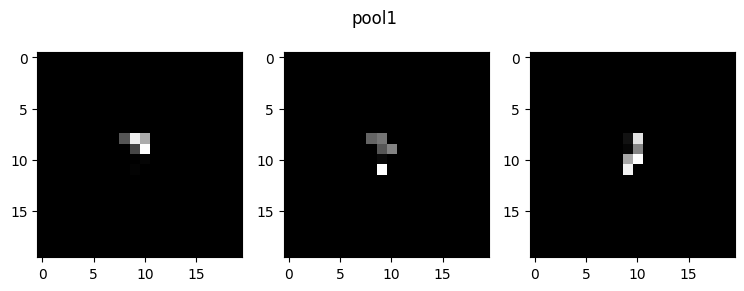

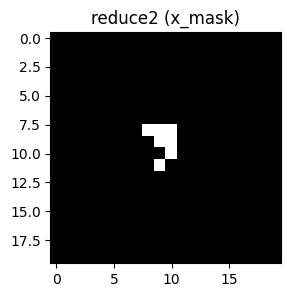

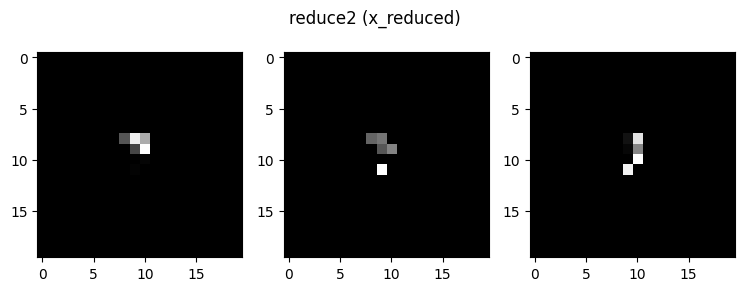

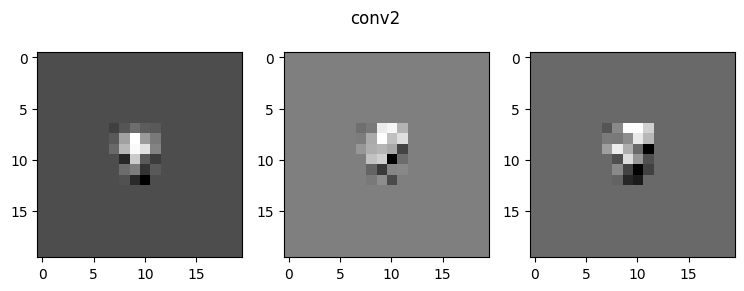

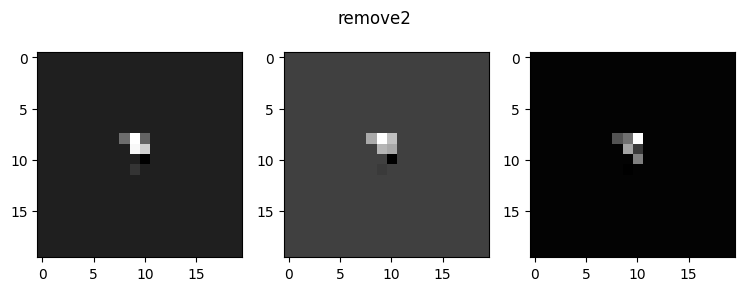

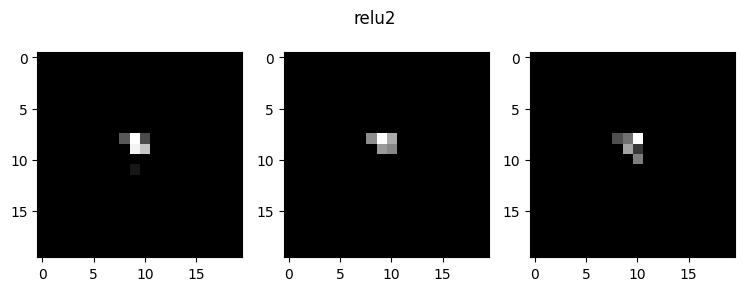

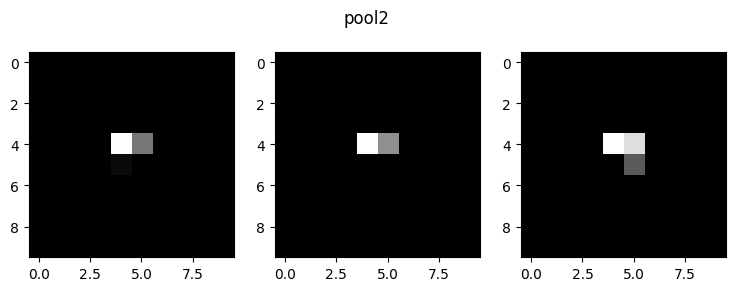

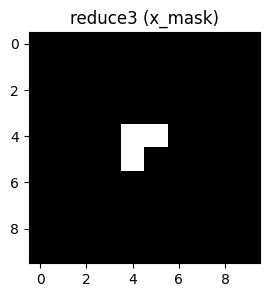

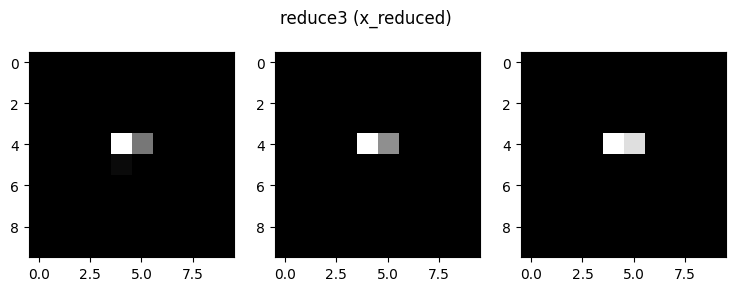

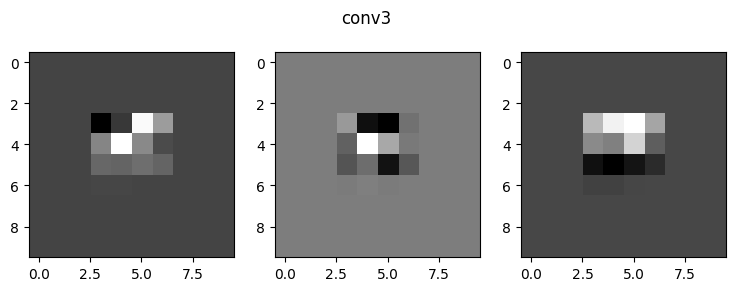

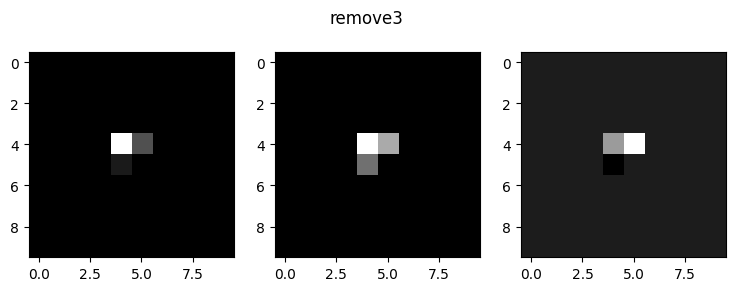

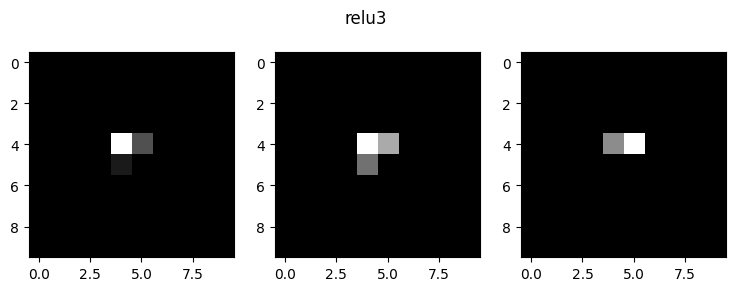

In [34]:
layer_names = [
    'x_in', 'reduce1',
    'conv1', 'remove1', 'relu1',
    'pool1', 'reduce2',
    'conv2', 'remove2', 'relu2',
    'pool2', 'reduce3',
    'conv3', 'remove3', 'relu3',
]

plot_tensors = []
plot_names = []
for name in layer_names:
    layer = cnn_sparse.get_layer(name)
    output = layer.output
    if isinstance(output, (list, tuple)):
        plot_tensors.append(output[1])
        plot_names.append(f'{name} (x_mask)')
        plot_tensors.append(output[0])
        plot_names.append(f'{name} (x_reduced)')
    else:
        plot_tensors.append(output)
        plot_names.append(name)

model_cnnpart = models.Model(inputs=cnn_sparse.input, outputs=plot_tensors)
layers_pred = model_cnnpart.predict(x_test[0:1])

for name, pred in zip(plot_names, layers_pred):
    arr = np.squeeze(pred)
    
    if arr.ndim==2:
        plt.figure(figsize=(3,3))
        plt.title(name)
        plt.imshow(arr, cmap='grey')
        plt.show()

    elif arr.ndim==3:
        h, w, c = arr.shape
        fig, axes = plt.subplots(1, c, figsize=(c*3,3))
        fig.suptitle(name, fontsize=12)
        for ch in range(c):
            ax = axes[ch] if c>1 else axes
            ax.imshow(arr[..., ch], cmap='grey')
        plt.show()